# Data Science Project Report

## Table of contents

* [1. Importing modules & data](#section1)
* [2. Exporatory Data Analysis](#section2)
    * [2.1 Target Variable](#section2.1)
    * [2.2 Numeric Features](#section2.2)
    * [2.3 Latitude & Longitude](#section2.3)
    * [2.4 Other features](#section2.4)
* [3. Feature Engineering](#section3)
* [4. Feature Selection](#section4)
    * [4.1 Splitting data into train, validate, test](#section4.1)
    * [4.2 Variance](#section4.2)
    * [4.3 Correlation](#section4.3)
    * [4.4 Dependency on target variable](#section4.4)
* [5. Model Tuning](#section5)
    * [5.1 Decision Tree Grid Search](#section5.1)
    * [5.2 Training the model](#section5.2)
    * [5.3 Model accuracy](#section5.3)
    * [5.4 Tree Visualisation](#section5.4)
    * [5.5 Random Forest Grid Search](#section5.5)
    * [5.6 Feature Importances](#section5.6)
    * [5.7 SHAP Values](#section5.7)
    * [5.8 Final fit on test data](#section5.8)

<a id='section1'></a>

### Importing modules & data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split
import scipy
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [2]:
df = pd.read_json('../Project/train.json')
df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium


<a id='section2'></a>

### Exploratory Data Analysis

First of all, let's take a look at the shape and columns of the dataset.

In [3]:
df.shape

(49352, 15)

In [4]:
df.columns

Index(['bathrooms', 'bedrooms', 'building_id', 'created', 'description',
       'display_address', 'features', 'latitude', 'listing_id', 'longitude',
       'manager_id', 'photos', 'price', 'street_address', 'interest_level'],
      dtype='object')

It seems that at the beginning and the end of the month there less entries for houses. In the middle of the month, especially the 12th and 21st day of the month there are surprisingly more entries than usual. Let's see if there is any evidence that this feature varies between the interest level.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [6]:
print(df.dtypes.value_counts()) #Number of columns with different datatypes

object     9
float64    3
int64      3
dtype: int64


The dataset has numerical features, categorical features, date feature, text features and image features. These need to be taken into consideration when cleaning our data in a later point. In fact, we are dealing with 9 non-numeric features which need to be dealt with since to train model, all data must be numeric.

Another requirement to train a model is that the data must not contain any null values, since a model cannot handle missing values. So next, we will check if there are any missing values.

In [7]:
df.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

Looks good. The dataset is free of null values.

Let's get a better understanding of the numerical variables.

In [8]:
df.describe().round()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.0,49352.0,49352.0,49352.0,49352.0,49352.0
mean,1.0,2.0,41.0,7024055.0,-74.0,3830.0
std,1.0,1.0,1.0,126275.0,1.0,22067.0
min,0.0,0.0,0.0,6811957.0,-118.0,43.0
25%,1.0,1.0,41.0,6915888.0,-74.0,2500.0
50%,1.0,1.0,41.0,7021070.0,-74.0,3150.0
75%,1.0,2.0,41.0,7128733.0,-74.0,4100.0
max,10.0,8.0,45.0,7753784.0,0.0,4490000.0


Looking at the table, we can immediately spot some outliers. There seems to be an apartment with 10 bathrooms and one with 8 bedrooms. Furthermore, we can see that the cheapest apartment seems to cost only 43 dollar which cannot be realistic and the most expensive apartment 4,490,000 dollars per month. Besides, a latitude of 0 which refers to the equator and a longitude of 0 which refers to Greenwhich, England, indicate wrong entries.

Since we have noticed outliers in our statistics table, let's have a closer look at them. In this regard we're going to start with numercial features first. Looks like bathrooms, bedrooms and price are the only numeric variables that can be used right away. Let's create the number of photos and number of features per listing. Longitude and latitude will be investigated later.

In [9]:
#creating variables for number of features and number of photos

df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)

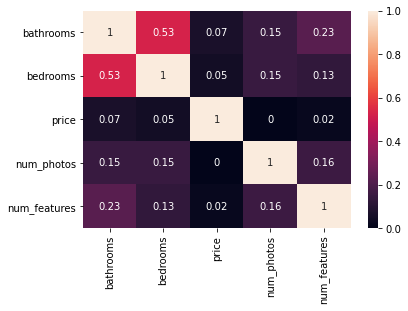

In [10]:
#correlation of numeric features

correlation_matrix = df[['bathrooms', 'bedrooms', 'price', 'num_photos', 'num_features']].corr().round(2)
_ = sns.heatmap(data=correlation_matrix, annot=True)

There seems to be some colinearity between bedrooms and bathrooms.

<a id='section2.1'></a>

**Target Variable**

The level of interest defined by the number of inquiries per apartment will be our target variable. Therefore, let's discover the distribution of the three different levels of interest.

In [11]:
df['interest_level'].describe()

count     49352
unique        3
top         low
freq      34284
Name: interest_level, dtype: object

The summary statistics are aligned with that of a categorical variable since the result's index includes count, unique, top, and freq. We can see the number of observations (49,352), and the number of unique values (3) which is correct since we have low, medium and high. Moreover we can see that "low" is considered top which means it is the most common value and its frequency is 34,284.

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64


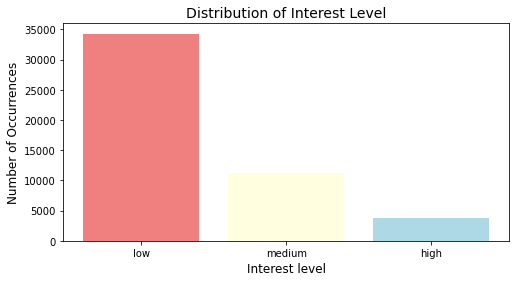

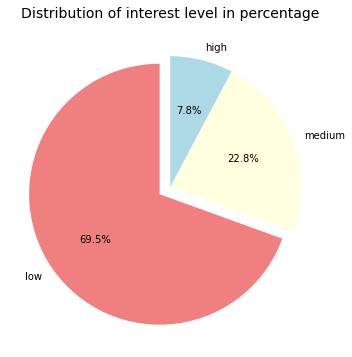

In [12]:
# Interest Level
int_level = df['interest_level'].value_counts()
print(int_level)

# Histogram
plt.figure(figsize=(8,4))
plt.bar(int_level.index, int_level.values, color=['lightcoral', 'lightyellow', 'lightblue'])
plt.title('Distribution of Interest Level', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Interest level', fontsize=12)
plt.show()

# Pie chart: slices will be ordered and plotted counter-clockwise
fig = plt.figure(figsize=(6,6))
labels = "low","medium","high"
sizes = df.interest_level.value_counts().values
explode=[0.1,0,0] # Only "explode" the 1st slice (low)
colors = ['lightcoral','lightyellow','lightblue']
patches, texts,autotexts= plt.pie(sizes, labels=labels,colors=colors,explode=explode,autopct="%1.1f%%",
                        startangle=90)
plt.title("Distribution of interest level in percentage", fontsize=14)
plt.show()

Taking a look into the histogram an pie chart, it confirms what we have observed from the summary statistics. Low is the most common value with a frequency of almost 35.000 which coverst 69,5 % of the interest level data.

<a id='section2.2'></a>

**Numeric Features**

* bathrooms
* bedrooms
* price

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
10.0        1
6.5         1
7.0         1
Name: bathrooms, dtype: int64


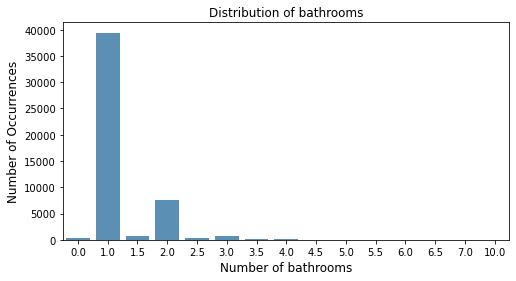

In [13]:
#bathrooms

cnt_srs = df['bathrooms'].value_counts()
print(cnt_srs)

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of bathrooms', fontsize=12)
plt.title('Distribution of bathrooms')
plt.show()

According to the list and histogram above, we can see that the majority of apartments have 1 bathroom. Regarding outliers, we can see that not many apartments have more than 5 bathrooms.

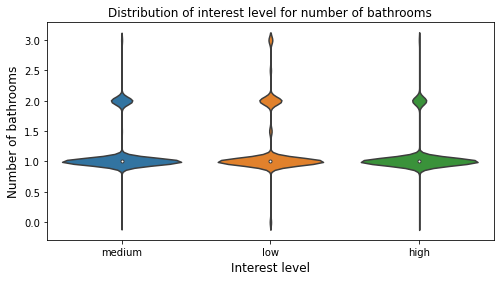

In [14]:
df['bathrooms'].loc[df['bathrooms']>3] = 3
plt.figure(figsize=(8,4))
sns.violinplot(x='interest_level', y='bathrooms', data=df)
plt.xlabel('Interest level', fontsize=12)
plt.ylabel('Number of bathrooms', fontsize=12)
plt.title('Distribution of interest level for number of bathrooms')
plt.show()

The number of bathrooms is distributed about the same among the different levels of interest. Interesting!

1    15752
2    14623
0     9475
3     7276
4     1929
5      247
6       46
8        2
7        2
Name: bedrooms, dtype: int64


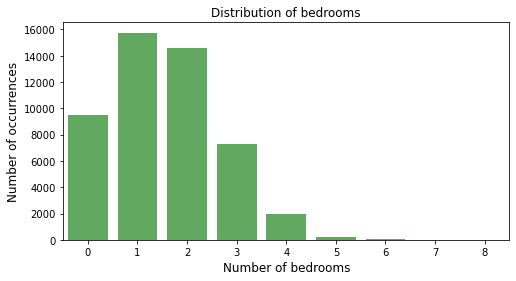

In [15]:
#bedrooms

cnt_srs = df['bedrooms'].value_counts()
print(cnt_srs)

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Number of bedrooms', fontsize=12)
plt.title('Distribution of bedrooms')
plt.show()

According to list and histogram above, we can see that the majority of apartments have 1 bedroom. Regarding outliers, we can see that not many apartments have more than 5 bedrooms.

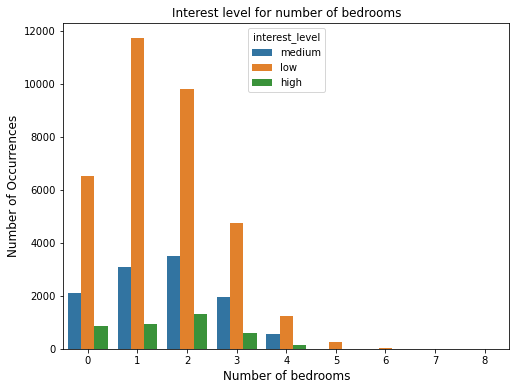

In [16]:
cc = ['lightcoral','lightyellow','lightblue']

plt.figure(figsize=(8,6))
sns.countplot(x='bedrooms', hue='interest_level', data=df)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of bedrooms', fontsize=12)
plt.title('Interest level for number of bedrooms')
plt.show()

Again it looks like the number of bedrooms does not tell us much about the interest level of an apartment.

In [17]:
#price

df['high_priced'] = 0
for row in df.index:
    if df['price'][row] > np.percentile(df['price'],99): #flag every price that exceeds treshold
        df['high_priced'][row] = 1
    else:
        pass

The best way to keep as much data and information as possible would be to impute high prices with the 99-quantile and flag the entries that were higher with a dummy variable.

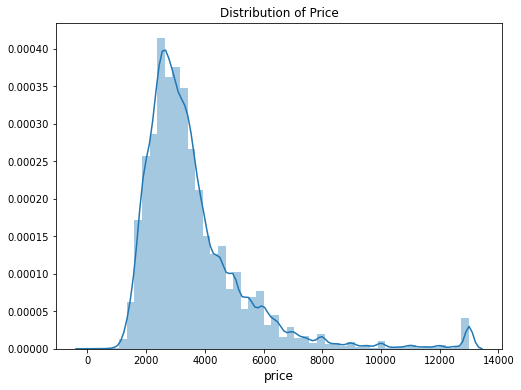

In [18]:
#price

ulimit = np.percentile(df.price.values, 99)
df['price'].loc[df['price']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(df.price.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.title('Distribution of Price')
plt.show()

The price is skewed to the right. Most apartment prices lie between 2000 and 4000 USD.

In [19]:
print(df.price.sort_values(ascending=False).head(8))
print(df.price.sort_values(ascending=False).tail(8))

95222     13000.0
84292     13000.0
514       13000.0
118212    13000.0
19375     13000.0
5602      13000.0
37628     13000.0
84318     13000.0
Name: price, dtype: float64
22693     700.0
85617     695.0
102756    695.0
113552    695.0
113599    695.0
117339    401.0
87511      45.0
53144      43.0
Name: price, dtype: float64


According to the plot, we can see that there are some outliers. If we sort the values, it appears that there are a number of very expensive apartments above 10,000 dollars. These outliers seem to be correct, since it is quite likely to find expensive apartments in New York. Additionally, there are unrealistic apartment prices for 43 dollar and 45 dollar which can be dropped since they are clearly wrong entries. 

In [20]:
#df = df[(df['price'] > 100)]
df_clean =df[df["price"]>100]

In [21]:
#Doublecheck
print(df_clean.price.sort_values(ascending=False).tail())

102756    695.0
85617     695.0
113552    695.0
113599    695.0
117339    401.0
Name: price, dtype: float64


In addition, we further noticed in the summary statistics that a latitude and longitude of 0 imply missing values. That is why in the next step, we want to check how many apartments are affected by that and take a closer look into latitude and longitude in general.

**Latitude & Longitude**

In [22]:
df_missing_ll = df[(df.latitude==0) | (df.longitude==0)]
print(len(df_missing_ll))

12


12 apartments have wrong longitude and latitude entries and can be droppped.

In [23]:
df_clean = df_clean[(df_clean.longitude!=0) | (df_clean.latitude!=0)]

In [24]:
#doublecheck
df_clean_missing_ll = df_clean[(df_clean.latitude==0) | (df_clean.longitude==0)]
print(len(df_clean_missing_ll))

0


<a id='section2.3'></a>

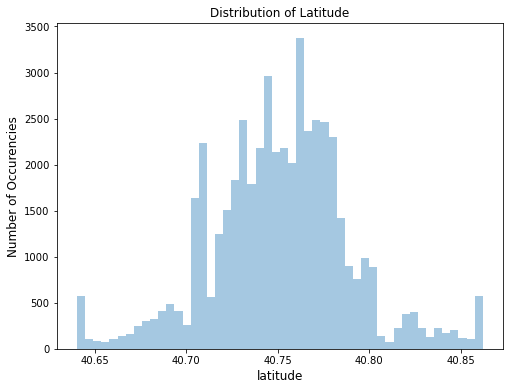

In [25]:
#latitude

llimit = np.percentile(df.latitude.values, 1)
ulimit = np.percentile(df.latitude.values, 99)
df['latitude'].loc[df['latitude']<llimit] = llimit
df['latitude'].loc[df['latitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(df.latitude.values, bins=50, kde=False)
plt.xlabel('latitude', fontsize=12)
plt.ylabel('Number of Occurencies', fontsize=12)
plt.title('Distribution of Latitude', fontsize=12)
plt.show()

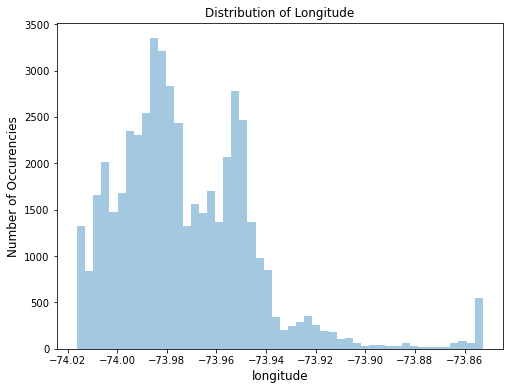

In [26]:
#longitude

llimit = np.percentile(df.longitude.values, 1)
ulimit = np.percentile(df.longitude.values, 99)
df['longitude'].loc[df['longitude']<llimit] = llimit
df['longitude'].loc[df['longitude']>ulimit] = ulimit

plt.figure(figsize=(8,6))
sns.distplot(df.longitude.values, bins=50, kde=False)
plt.xlabel('longitude', fontsize=12)
plt.ylabel('Number of Occurencies', fontsize=12)
plt.title('Distribution of Longitude', fontsize=12)
plt.show()

Latitude and longitude correspond to the coordinates of NYC.

Let's make another plot to cover the area and also see how our target value is linked to latitude and longitude.

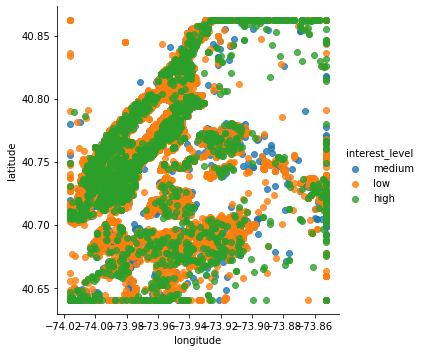

In [27]:
df_l=df[df['latitude']!=0]
df_l=df_l[df_l['latitude']<42]
df_l=df_l[df_l['longitude']>-80]
g=sns.lmplot(x='longitude',y='latitude',data=df_l,hue='interest_level',fit_reg=False)

In [28]:
# Narrow down to NYC coordinates

df_clean = df_clean[(df_clean['latitude']>40.55) &
(df_clean['latitude']<40.94) &
(df_clean['longitude']>-74.1) &
(df_clean['longitude']<-73.67)]
df = df_clean

The main dots seem to mark the area of manhatten while also some outliers can be spotted. However, it is difficult to tell from the plot so we might need to look into the areas in more detail later on.

<a id='section2.4'></a>

**Other features**

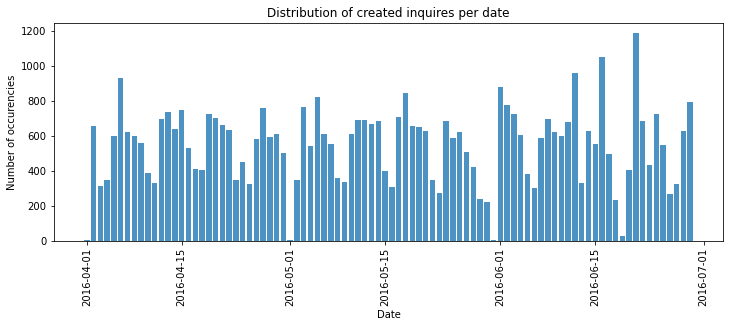

In [29]:
#date created

df["created"] = pd.to_datetime(df["created"])
df["date_created"] = df["created"].dt.date
cnt_srs = df['date_created'].value_counts()


plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')
plt.xlabel('Date')
plt.ylabel('Number of occurencies')
plt.title('Distribution of created inquires per date')
plt.show()

The dates range from April to June 2015. Let's see in the next step if we can find a corelation between the interest level and the day of week.

In [30]:
df['date_converted'] = pd.to_datetime(df['created'])

In [31]:
df['date_converted'].head()

4    2016-06-16 05:55:27
6    2016-06-01 05:44:33
9    2016-06-14 15:19:59
10   2016-06-24 07:54:24
15   2016-06-28 03:50:23
Name: date_converted, dtype: datetime64[ns]

In [32]:
df['weekday'] = df['date_converted'].apply(lambda x: x.day_name())

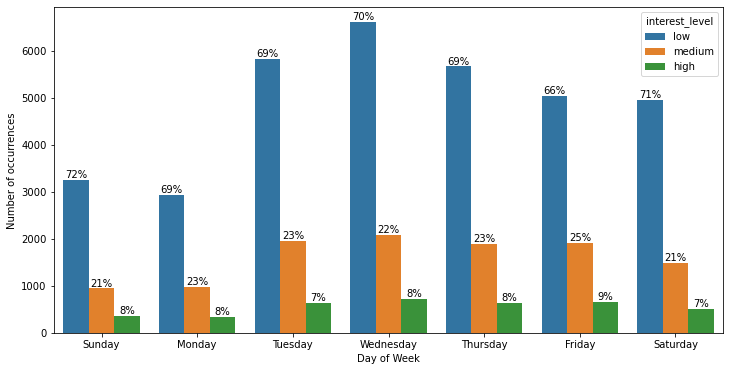

In [33]:
# Iterest per Day of Week
fig = plt.figure(figsize=(12,6))
ax = sns.countplot(x='weekday', hue = 'interest_level',
                   hue_order=['low', 'medium', 'high'], data=df,
                   order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']);
plt.xlabel('Day of Week');
plt.ylabel('Number of occurrences');

# Adding percents over bars
height = [p.get_height() for p in ax.patches]
ncol = int(len(height)/3)
total = [height[i] + height[i + ncol] + height[i + 2*ncol] for i in range(ncol)] * 3
for i, p in enumerate(ax.patches):    
    ax.text(p.get_x()+p.get_width()/2,
            height[i] + 50,
            '{:1.0%}'.format(height[i]/total[i]),
            ha="center") 

Here we can see that most entries are created in the middle of the week. However, looking at our target value, it seems to be equally distributed.

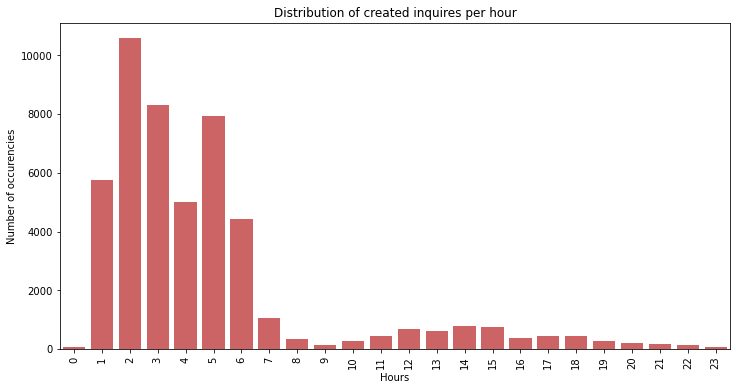

In [34]:
#add new feature: hour created

df["hour_created"] = df["created"].dt.hour
cnt_srs = df['hour_created'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.xlabel('Hours')
plt.ylabel('Number of occurencies')
plt.title('Distribution of created inquires per hour')
plt.show()

Listings are created in the early hours (1-7am) of the day.

**Month**

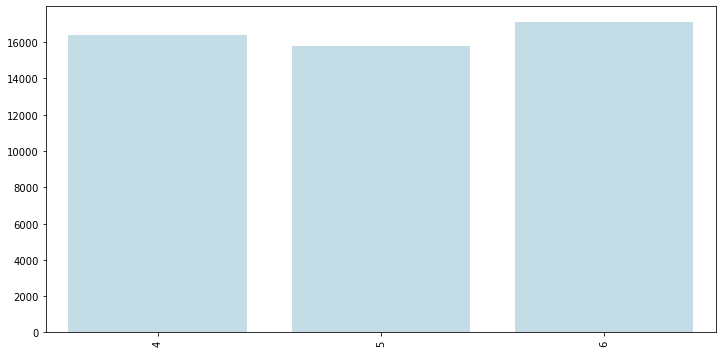

In [35]:
df["created"] = pd.to_datetime(df["created"])
df["month"] = df["created"].dt.month # storing data as day of month

month = df["month"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(month.index, month.values, alpha=0.8, color='lightblue')
plt.xticks(rotation='vertical')
plt.show()

We can see that there are only entries in april, may and june. Let's see if these have an impact on the interest_level.

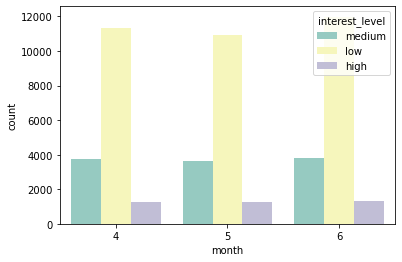

In [36]:
sns.countplot(x="month", hue= df['interest_level'], data=df, palette="Set3")

As we can see these have no value for interest level. Let us also try the same for day of week and day of month!

**Day of month**

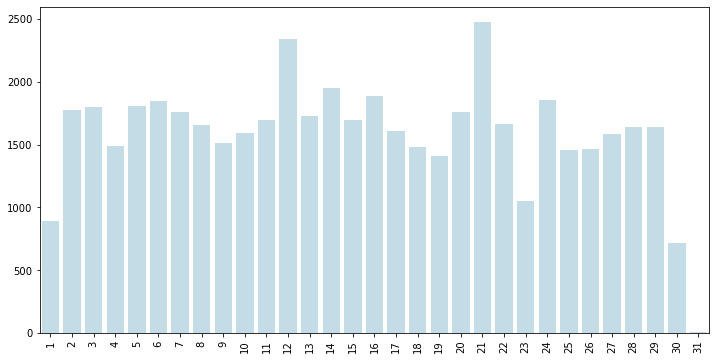

In [37]:
df["created"] = pd.to_datetime(df["created"])
df["dayofmonth"] = df["created"].dt.day # storing data as day of month

day_count = df["dayofmonth"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(day_count.index, day_count.values, alpha=0.8, color='lightblue')
plt.xticks(rotation='vertical')
plt.show()

It seems that at the beginning and the end of the month there are less entries for houses. In the middle of the month, especially the 12th and 21st day of the month there are surprisingly more entries than usual. Let's see if there is any evidence that this feature varies between the interest level.

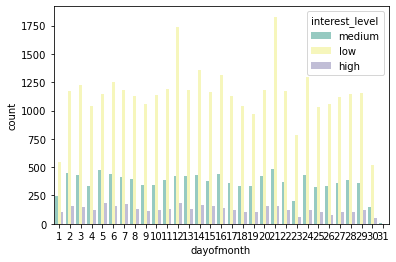

In [38]:
sns.countplot(x="dayofmonth", hue = df['interest_level'], data=df, palette="Set3")

We can see that they are pretty much equally distributed.

Display_address that appear less than 2 times: 63.15%
Display_address that appear less than 10 times: 89.55%
Display_address that appear less than 50 times: 97.72%
Display_address that appear less than 100 times: 99.26%
Display_address that appear less than 500 times: 100.0%


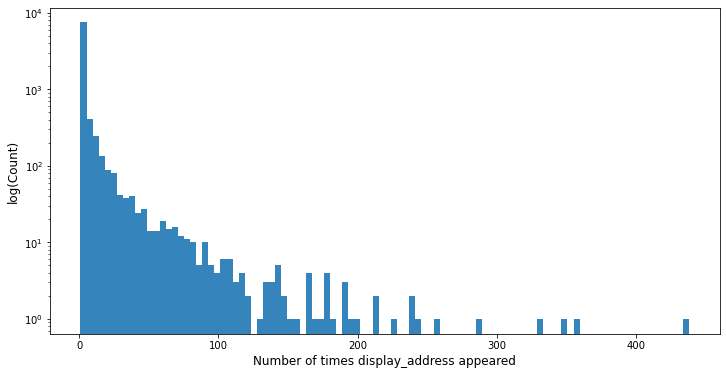

In [39]:
#display address

cnt_srs = df.groupby('display_address')['display_address'].count()

for i in [2, 10, 50, 100, 500]:
    print('Display_address that appear less than {} times: {}%'.format(i, round((cnt_srs < i).mean() * 100, 2)))

plt.figure(figsize=(12, 6))
plt.hist(cnt_srs.values, bins=100, log=True, alpha=0.9)
plt.xlabel('Number of times display_address appeared', fontsize=12)
plt.ylabel('log(Count)', fontsize=12)
plt.show()

Most of the display addresses occur less than 100 times in the given dataset. None of the display address occur more than 500 times.

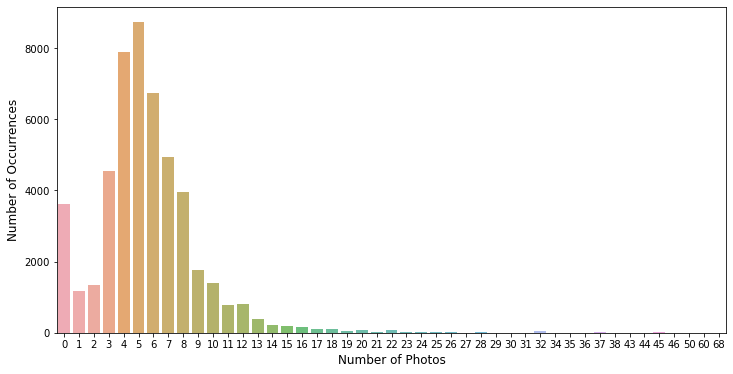

In [40]:
#number of photos

cnt_srs = df['num_photos'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

Most listings have 5 photos attatched to them.

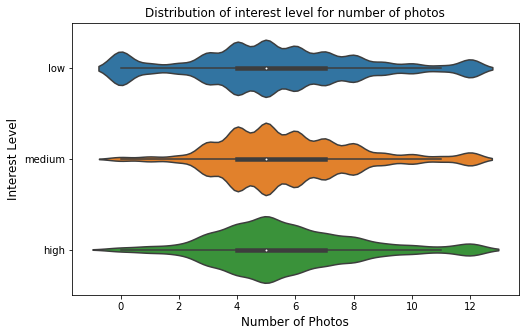

In [41]:
df['num_photos'].loc[df['num_photos']>12] = 12
plt.figure(figsize=(8,5))
sns.violinplot(x="num_photos", y="interest_level", data=df, order =['low','medium','high'])
plt.xlabel('Number of Photos', fontsize=12)
plt.ylabel('Interest Level', fontsize=12)
plt.title('Distribution of interest level for number of photos')
plt.show()

The number of photos does not seem to have an impact on the level of interest.

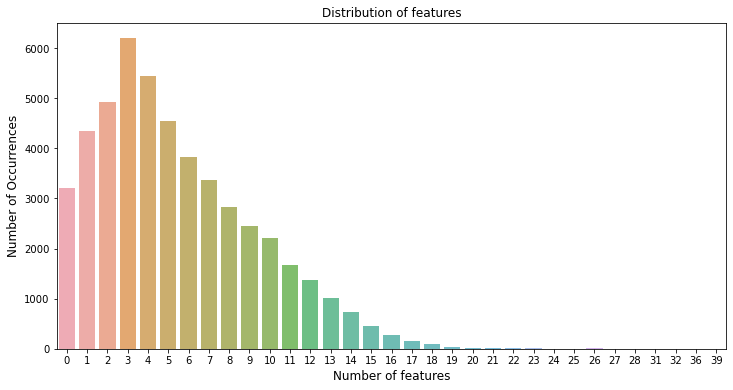

In [42]:
#Feature number

cnt_srs = df['num_features'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of features', fontsize=12)
plt.title('Distribution of features')
plt.show()

Most listings have 3 features. Around 3000 apartments do not have any features listed at all.

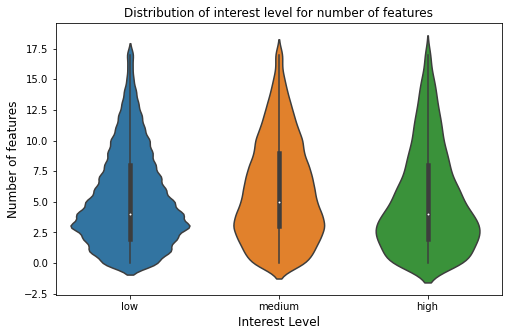

In [43]:
#add new feature: number of features

df['num_features'].loc[df['num_features']>17] = 17
plt.figure(figsize=(8,5))
sns.violinplot(y="num_features", x="interest_level", data=df, order =['low','medium','high'])
plt.xlabel('Interest Level', fontsize=12)
plt.ylabel('Number of features', fontsize=12)
plt.title('Distribution of interest level for number of features')
plt.show()

Also the number of features does not seem to influence the level of interest too much. Good to know!

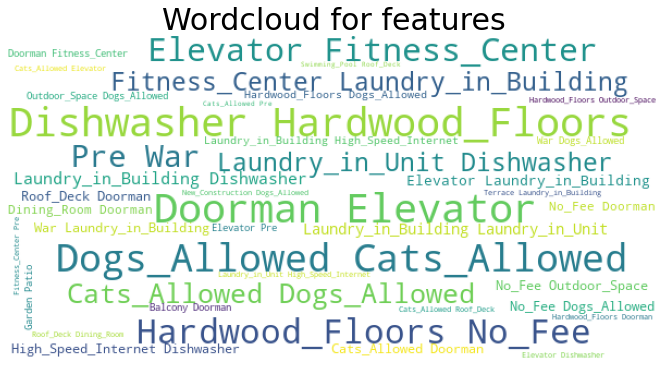

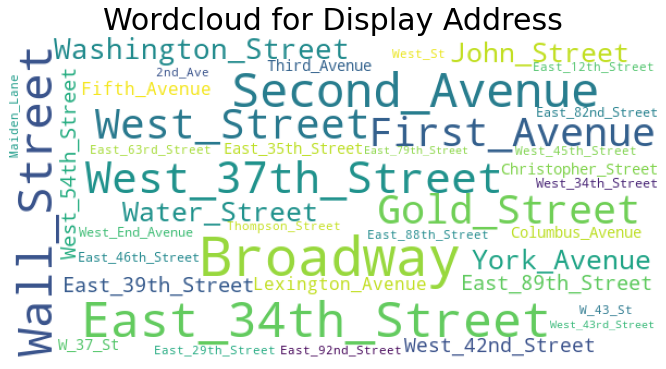

In [44]:
#wordclouds for features

text = ''
text_da = ''
text_desc = ''
for ind, row in df.iterrows():
    for feature in row['features']:
        text = " ".join([text, "_".join(feature.strip().split(" "))])
    text_da = " ".join([text_da,"_".join(row['display_address'].strip().split(" "))])
text = text.strip()
text_da = text_da.strip()
text_desc = text_desc.strip()

plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for features", fontsize=30)
plt.axis("off")
plt.show()

#wordcloud for display address

plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text_da)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for Display Address", fontsize=30)
plt.axis("off")
plt.show()

In [ ]:
df.to_json("cleaned_data.json")

<a id='section3'></a>

### Feature Engineering

Due to high consumption of computational power as well as execution time, the feature engineering part of this report has been outsourced to another notebook allowing for an easier exececution flow. The output is provided as a csv file and therefore imported below.

In [4]:
df = pd.read_json('../Project/feature_engineering.json') #engine='python'

<a id='section4'></a>

### Feature Selection

<a id='section4.1'></a>

**Splitting data into train, validate, test**

Let's take a look at the new dataset and new columns that have been added during the feature engineering step.

In [46]:
df.head(3)

,bathrooms,bedrooms,manager_id,interest_level,high_priced,date_created,date_converted,weekday,hour_created,month,...,avg_price_hood,avg_price_postal,avg_price_boroughs,avg_price_county,high_frac,low_frac,medium_frac,manager_skill,log_price,sqrt_price
0,1,1,2187,2,0,76,41072,4,5,2,...,-1.309290,-0.507221,-1.984241,-1.984197,0.008079,0.012009,-0.022237,-0.005251,-0.750890,-0.720723
1,1,2,2039,1,0,61,32014,6,5,2,...,0.311997,0.278472,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,0.354353,0.230091
2,1,2,2742,2,0,74,39726,5,15,2,...,0.311997,0.343407,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,0.153120,0.040323


Below we can see that the dataframe with the engineered features now contains 83 columns. Originally, there were only 19.

In [47]:
df.shape

(48848, 92)

In [48]:
df.columns

Index(['bathrooms', 'bedrooms', 'manager_id', 'interest_level', 'high_priced',
       'date_created', 'date_converted', 'weekday', 'hour_created', 'month',
       'dayofmonth', 'num_redacted', 'room_sum', 'phone', 'email',
       'neighborhood', 'postal', 'boroughs', 'county', 'geo', 'subway', 'park',
       'latitude', 'longitude', 'price', 'num_photos', 'num_features',
       'num_description', 'len_cleaned_description', 'similarity_address',
       'dining_room', 'pre_war', 'laundry_in_building', 'dishwasher',
       'hardwood_floors', 'dogs_allowed', 'cats_allowed', 'doorman',
       'elevator', 'no_fee', 'laundry_in_unit', 'fitness_center', 'loft',
       'fireplace', 'roof_deck', 'high_speed_internet', 'swimming_pool',
       'wheelchair_access', 'reduced_fee', 'common_outdoor_space',
       'parking_space', 'balcony', 'private_outdoor_space', 'publicoutdoor',
       'garage', 'garden', 'patio', 'new_construction', 'furnished',
       'exclusive', 'terrace', 'outdoor_space', 'liv

Now, we need to split up the data into train, test and validation sets. The model trains just on the training set and model accuracy is evaluated using the validation set during development. After tuning the model on the validation set, we run the test set through the model to get our final measure of model accuracy

In [49]:
#creating train, test and validate set

np.random.seed(123)
df = df.sample(frac=1) #shuffle data
df_dev, df_test = train_test_split(df, test_size=0.15)
df_train, df_valid = train_test_split(df_dev, test_size=0.15)

In the following we can see to which proportions our dataset has been split up. Of course, the train test is supposed to be the biggest in order to allow for a better fitted model.

In [50]:
df_test.shape

(7328, 92)

In [51]:
df_train.shape

(35292, 92)

In [52]:
df_valid.shape

(6228, 92)

In [53]:
X_train = df_train.drop(columns='interest_level')
y_train = df_train.interest_level 

In the following sections, the feature selection will be made according to the features variance, correlation and dependency on the interest level.

<a id='section4.2'></a>

**Variance**

As a first step, it will be checked if the variance of the features is low or close to zero. If so, it indicates that a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed.

In [54]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=.2)
var_thres.fit(X_train)

VarianceThreshold(threshold=0.2)

In [55]:
len(X_train.columns[var_thres.get_support()])

87

In [56]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]

print(len(constant_columns))

4


In [57]:
for column in constant_columns:
    print(column)

high_priced
boroughs
subway
park


These 4 features fall into our treshold of 0.2 and thus will be removed. 

In [58]:
X_train = X_train.drop(constant_columns, axis=1)
X_train

,bathrooms,bedrooms,manager_id,date_created,date_converted,weekday,hour_created,month,dayofmonth,num_redacted,...,avg_price_hood,avg_price_postal,avg_price_boroughs,avg_price_county,high_frac,low_frac,medium_frac,manager_skill,log_price,sqrt_price
3089,3,4,1625,74,39942,5,15,2,13,1,...,1.132925,1.708734,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,1.716532,1.746277
1592,1,1,1450,66,34856,1,2,2,5,1,...,0.108321,0.086728,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,0.286960,0.165651
7634,1,0,1496,86,46277,3,2,2,25,0,...,1.166754,0.884112,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,0.162050,0.048577
34726,1,2,1886,27,14597,4,3,0,27,1,...,-1.901360,-1.614010,0.393986,0.393977,-0.969265,1.660343,-1.517425,-1.529296,-0.801526,-0.759269
29427,1,2,2556,56,30536,0,5,1,26,1,...,0.311997,0.278472,0.393986,0.393977,-0.969265,-0.377875,1.233404,-0.110108,0.430971,0.304456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,1,0,2021,85,45785,2,2,2,24,1,...,-1.309290,0.884112,0.393986,0.393977,-0.969265,1.048878,-0.692177,-1.103540,-0.295735,-0.355416
46699,3,4,3128,8,4255,2,3,0,8,1,...,0.311997,0.842163,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,1.823679,1.884757
32206,1,2,967,40,20880,6,1,1,10,0,...,0.094984,0.159773,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,-0.657522,-0.648578
14520,1,2,605,82,44416,6,6,2,21,1,...,0.892469,-0.391377,0.393986,0.393977,0.008079,0.012009,-0.022237,-0.005251,-0.605079,-0.607436


<a id='section4.3'></a>

**Correlation**

Next, features with a high correlation will be removed.

In [59]:
# Pearson Correlation
#plt.figure(figsize=(20,20))
#cor = X_train.corr()
#sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
#plt.show()

The heatmap which was created in the code above turned out not to be useful since it was not readable given the huge amount of features in our dataset. In order to get rid of high correlated features, again a treshold will be set with the help of a function.

In [60]:
# Remove the first feature that is correlated with any other feature

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i] # get name of column
                col_corr.add(colname)
    return col_corr

In [61]:
corr_features = correlation(X_train, 0.7)
len(set(corr_features))

19

19 features were identified with a high correlation! Let's see wich features we are talking about.

In [62]:
corr_features

{'avg_price_boroughs',
 'avg_price_county',
 'avg_price_postal',
 'date_converted',
 'dogs_allowed',
 'furnished',
 'high_ceilings',
 'latitude',
 'len_cleaned_description',
 'log_price',
 'manager_skill',
 'medium_frac',
 'month',
 'prewar',
 'price',
 'price_per_room',
 'price_type',
 'room_sum',
 'sqrt_price'}

In [63]:
df_corr = X_train[['avg_price_boroughs',
 'avg_price_county',
 'avg_price_postal',
 'date_converted',
 'dogs_allowed',
 'furnished',
 'high_ceilings',
 'latitude',
 'len_cleaned_description',
 'log_price',
 'manager_skill',
 'medium_frac',
 'month',
 'prewar',
 'price',
 'price_per_room',
 'price_type',
 'room_sum',
 'sqrt_price']]
df_corr

,avg_price_boroughs,avg_price_county,avg_price_postal,date_converted,dogs_allowed,furnished,high_ceilings,latitude,len_cleaned_description,log_price,manager_skill,medium_frac,month,prewar,price,price_per_room,price_type,room_sum,sqrt_price
3089,0.393986,0.393977,1.708734,39942,-0.767156,-0.127282,-0.136675,-0.806670,-0.196164,1.716532,-0.005251,-0.022237,2,-0.203319,1.666641,-0.691901,-1.096371,7,1.746277
1592,0.393986,0.393977,0.086728,34856,-0.767156,-0.127282,-0.136675,0.102625,0.205972,0.286960,-0.005251,-0.022237,2,-0.203319,0.046465,0.563093,0.074022,2,0.165651
7634,0.393986,0.393977,0.884112,46277,-0.008147,-0.127282,-0.136675,-0.165734,1.060511,0.162050,-0.005251,-0.022237,2,-0.203319,-0.054526,2.901757,2.097625,1,0.048577
34726,0.393986,0.393977,-1.614010,14597,0.029505,8.158398,7.548541,1.913396,-0.095630,-0.801526,-1.529296,-1.517425,0,-0.203319,-0.679914,-0.935690,-0.684425,3,-0.759269
29427,0.393986,0.393977,0.278472,30536,-0.767156,-0.127282,-0.136675,0.003618,-0.849634,0.430971,-0.110108,1.233404,1,-0.203319,0.169598,-0.197214,-0.599191,3,0.304456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,0.393986,0.393977,0.884112,45785,-0.767156,-0.127282,-0.136675,-0.353325,-0.346964,-0.295735,-1.103540,-0.692177,2,-0.203319,-0.382882,2.045444,2.002651,1,-0.355416
46699,0.393986,0.393977,0.842163,4255,-0.767156,-0.127282,-0.136675,-0.426277,-0.522899,1.823679,-0.005251,-0.022237,0,3.713507,1.831359,-0.630534,-1.091925,7,1.884757
32206,0.393986,0.393977,0.159773,20880,1.543626,-0.127282,-0.136675,0.626315,-1.201503,-0.657522,-0.005251,-0.022237,1,-0.203319,-0.601605,-0.867617,-0.674466,3,-0.648578
14520,0.393986,0.393977,-0.391377,44416,0.273027,-0.127282,-0.136675,-1.129743,1.990451,-0.605079,-0.005251,-0.022237,2,-0.203319,-0.571902,-0.841796,-0.670839,3,-0.607436


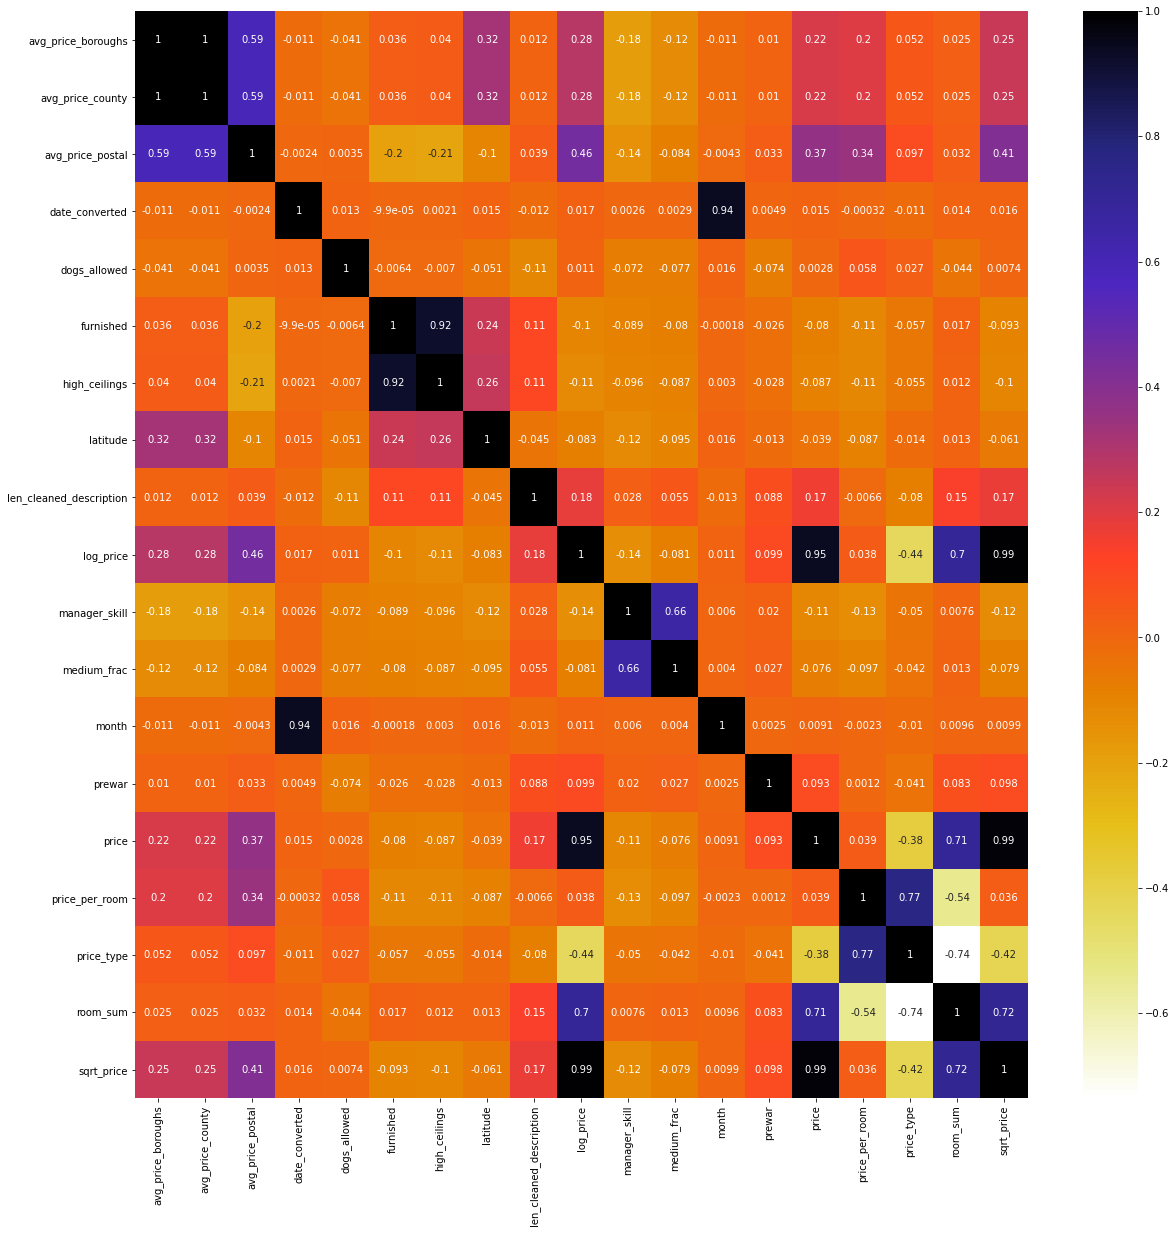

In [64]:
plt.figure(figsize=(20,20))
cor = df_corr.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

'avg_price_boroughs' and 'avg_price_county' correlate to 100%. They also correlate with 'avg_price_postal'. That is why 'avg_price_boroughs' and 'avg_price_postal' will be removed.  
 
'date_converted' strongly correlates with 'month' which is why 'date_converted' will be removed.

'furnished' strongly correlates with 'high_ceilings' which is why 'furnished' will be removed.

'log_price' strongly correlates with 'sqrt_price' which is why 'log_price' will be removed.

'manager_skill' highly correlated with 'medium_frac' which is why 'medium_frac' will be removed.

'price_type' is highly correlated with 'room_sum' and 'price_per_room' and 'room_sum' is highly correlated to 'sqrt_price'. Since 'price' is  still in the dataset, all these features related to price will be removed.

Moreover, although not shown in the heatmap, 'manager_id', 'manager_skills' and 'low_frac' as well as 'high_frac' is asumed to highly correlate as well since manager_id was the original feature that has been used within the feature engineering part. Same goes with 'latitude', 'longitude' and 'geo'. That is why another correlation matrix will be displayed for these features.


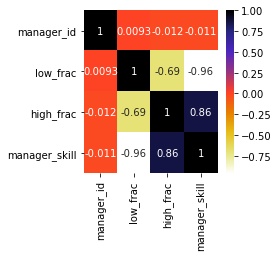

In [65]:
df_corr_ = X_train[['manager_id', 'low_frac', 'high_frac',
 'manager_skill']]

plt.figure(figsize=(3,3))
cor = df_corr_.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

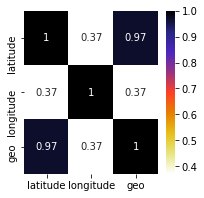

In [66]:
df_corr_ = X_train[['latitude', 'longitude', 'geo']]

plt.figure(figsize=(3,3))
cor = df_corr_.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

As assumed, there are strong correlations and that is why these features (except for longitude) will be removed along with the other correlated features. 

In [67]:
corr_features_drop = X_train[['avg_price_boroughs',
                              'avg_price_postal',
                              'sqrt_price',
                              'date_converted',
                              'furnished',
                              'log_price',
                              'medium_frac',
                              'price_type',
                              'room_sum',
                              'price_per_room',
                              'manager_id',
                              'low_frac',
                             'high_frac',
                             'latitude']] 
corr_features_drop 

,avg_price_boroughs,avg_price_postal,sqrt_price,date_converted,furnished,log_price,medium_frac,price_type,room_sum,price_per_room,manager_id,low_frac,high_frac,latitude
3089,0.393986,1.708734,1.746277,39942,-0.127282,1.716532,-0.022237,-1.096371,7,-0.691901,1625,0.012009,0.008079,-0.806670
1592,0.393986,0.086728,0.165651,34856,-0.127282,0.286960,-0.022237,0.074022,2,0.563093,1450,0.012009,0.008079,0.102625
7634,0.393986,0.884112,0.048577,46277,-0.127282,0.162050,-0.022237,2.097625,1,2.901757,1496,0.012009,0.008079,-0.165734
34726,0.393986,-1.614010,-0.759269,14597,8.158398,-0.801526,-1.517425,-0.684425,3,-0.935690,1886,1.660343,-0.969265,1.913396
29427,0.393986,0.278472,0.304456,30536,-0.127282,0.430971,1.233404,-0.599191,3,-0.197214,2556,-0.377875,-0.969265,0.003618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3613,0.393986,0.884112,-0.355416,45785,-0.127282,-0.295735,-0.692177,2.002651,1,2.045444,2021,1.048878,-0.969265,-0.353325
46699,0.393986,0.842163,1.884757,4255,-0.127282,1.823679,-0.022237,-1.091925,7,-0.630534,3128,0.012009,0.008079,-0.426277
32206,0.393986,0.159773,-0.648578,20880,-0.127282,-0.657522,-0.022237,-0.674466,3,-0.867617,967,0.012009,0.008079,0.626315
14520,0.393986,-0.391377,-0.607436,44416,-0.127282,-0.605079,-0.022237,-0.670839,3,-0.841796,605,0.012009,0.008079,-1.129743


In [68]:
X_train = X_train.drop(corr_features_drop, axis=1)

In [69]:
X_train.head()

,bathrooms,bedrooms,date_created,weekday,hour_created,month,dayofmonth,num_redacted,phone,email,...,high_ceilings,high_ceiling,laundry_room,renovated,dryer_in_unit,live_in_super,green_building,avg_price_hood,avg_price_county,manager_skill
3089,3,4,74,5,15,2,13,1,0,1,...,-0.136675,-0.078077,-0.065485,-0.234017,-0.211113,-0.060138,-0.165175,1.132925,0.393977,-0.005251
1592,1,1,66,1,2,2,5,1,0,0,...,-0.136675,-0.078077,-0.065485,3.532431,-0.211113,-0.060138,-0.165175,0.108321,0.393977,-0.005251
7634,1,0,86,3,2,2,25,0,1,1,...,-0.136675,-0.078077,14.925482,-0.234017,-0.211113,-0.060138,-0.165175,1.166754,0.393977,-0.005251
34726,1,2,27,4,3,0,27,1,1,1,...,7.548541,-0.078077,-0.065485,-0.234017,-0.211113,-0.060138,-0.165175,-1.901360,0.393977,-1.529296
29427,1,2,56,0,5,1,26,1,0,1,...,-0.136675,-0.078077,-0.065485,-0.234017,-0.211113,-0.060138,-0.165175,0.311997,0.393977,-0.110108


At this point, we reduced our features from 91 to 73.

<a id='section4.4'></a>

**Dependency on target variable**

In this step, the dependency of the features on our target value will be tested by means of the mutual_info_classif function.

In [70]:
from sklearn.feature_selection import mutual_info_classif
# Determine mutual information (information gain)
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([8.20110593e-03, 9.07028017e-03, 3.33047559e-03, 0.00000000e+00,
       2.75176348e-02, 2.38270318e-03, 0.00000000e+00, 8.21581313e-03,
       4.42662128e-03, 5.03642198e-03, 2.12170048e-03, 2.04970994e-02,
       9.24140942e-03, 7.76380695e-02, 3.75942092e-02, 5.58453768e-02,
       1.99686190e-02, 1.01731253e-03, 1.85098616e-02, 1.88230703e-02,
       5.35714665e-03, 9.67998303e-03, 3.83600711e-02, 0.00000000e+00,
       7.40096670e-03, 2.72210994e-02, 3.43030687e-02, 3.59447814e-02,
       1.22002575e-03, 3.64912052e-02, 4.40501281e-03, 0.00000000e+00,
       2.47632169e-02, 9.42272285e-04, 5.05447012e-03, 0.00000000e+00,
       0.00000000e+00, 3.02604983e-03, 2.64866052e-02, 1.68066891e-04,
       0.00000000e+00, 6.18002156e-03, 3.11999143e-03, 2.76280431e-02,
       9.79347146e-03, 2.20344795e-03, 3.15916251e-03, 4.42939155e-03,
       4.40304920e-03, 1.03286192e-03, 4.15727889e-03, 3.38378820e-02,
       1.14292927e-02, 0.00000000e+00, 3.13697218e-03, 5.43248808e-05,
      

Whichever has the highest value is the most important feature. Since it is not evident from the array, we will convert it into a series and sort the values respectively.

In [71]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

manager_skill           0.079474
geo                     0.077638
price                   0.055845
pre_war                 0.038360
longitude               0.037594
                          ...   
roof_deck               0.000000
weekday                 0.000000
common_outdoor_space    0.000000
green_building          0.000000
high_speed_internet     0.000000
Length: 73, dtype: float64

Interesting that cats_allowed belongs to the top 5! Let's plot the result in the next step.

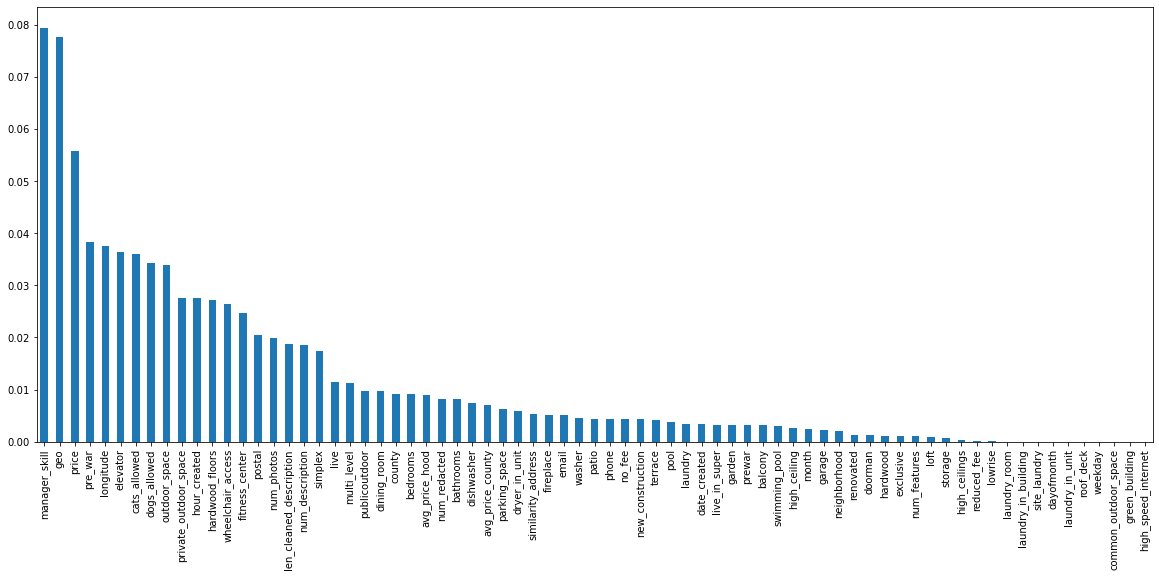

In [72]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20,8))

Now we can see very well which features are important for our model and which are less important. For our model, we are not going to use all the features. That is why in the next step, we will select the top 15. 

In [73]:
from sklearn.feature_selection import SelectKBest

In [74]:
sel_five_cols = SelectKBest(mutual_info_classif, k=8)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

Index(['geo', 'price', 'pre_war', 'dogs_allowed', 'cats_allowed', 'elevator',
       'outdoor_space', 'manager_skill'],
      dtype='object')

Now, as we have defined our top 8 features for our model, it is time to see how our model performs.

<a id='section5'></a>

### Model Tuning

In [75]:
#splitting up dependent and independent variables with output from feature selection

y_train = df_train.interest_level
X_train = df_train[['geo', 'price', 'pre_war', 'dogs_allowed', 'cats_allowed', 'elevator', 'outdoor_space', 'manager_skill']]

y_valid = df_valid.interest_level
X_valid = df_valid[['geo', 'price', 'pre_war', 'dogs_allowed', 'cats_allowed', 'elevator', 'outdoor_space', 'manager_skill']]

y_test = df_test.interest_level
X_test = df_test[['geo', 'price', 'pre_war', 'dogs_allowed', 'cats_allowed', 'elevator', 'outdoor_space', 'manager_skill']]

<a id='section5.1'></a>

**Decision Tree Grid Search**

Now, we are going to instantiate our model, which is a decision tree.

In [76]:
#instantiate dt classifier

dt = DecisionTreeClassifier()

Let's take a look at all parameters of a decision tree to decide which ones to tune.

In [77]:
#get parameters

dt.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

We have selected the most important hyperparamers for tuning a decision tree. In the next step, we create a grid consisting of dictionaries with different values for the respective parameters. The grid includes 5-fold cross validation and uses the previously created classifier as an estimator.

In [78]:
#define the grid of hyperparameters

params_dt = {'max_depth': range(1,10),
             'min_samples_leaf': range(1,5),
             'min_samples_split': range(1,10),
             'criterion': ['gini', 'entropy']}

#instantiate a 5-fold CV grid search object

grid_dt = GridSearchCV(estimator=dt, param_grid=params_dt, scoring='accuracy', cv=5, n_jobs=-1)

<a id='section5.2'></a>

**Training the model**

Let's fit the decision tree grid to the training data.

In [79]:
# fit grid to the training data

grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             scoring='accuracy')

Next, we take a look at which hyperparamters the grid has parsed to be the best.

In [80]:
#extract best hyperparameters from grid

best_hyperparams = grid_dt.best_params_
print('Best hyperparameters: \n', best_hyperparams)

Best hyperparameters: 
 {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 6}


<a id='section5.3'></a>

**Model Accuracy**

What was the best CV score?

In [81]:
#extract best CV score from grid

best_CV_score = grid_dt.best_score_
print('Best CV accuracy:', best_CV_score)

Best CV accuracy: 0.7202766216383458


Not too bad! Let's take the best performing model from the grid.

In [82]:
#extract best model from grid

best_clf = grid_dt.best_estimator_

In [83]:
#confusion matrix with validation set

y_valid_pred = best_clf.predict(X_valid)
confusion_matrix(y_valid, y_valid_pred)

array([[ 108,  286,   76],
       [  44, 4176,  119],
       [  66, 1173,  180]])

The above output shows a 3x3 confusion matrix, because the target variable has three levels: low, medium and high. Mostly, the medium level is falsely classified as it lies between the two other layers as can be seen above.

In [84]:
#evaluate accuracy with validation set

test_acc = best_clf.score(X_valid, y_valid)
print('Validation set accuracy of best model: {:.3f}'.format(test_acc))

Validation set accuracy of best model: 0.717


Seems like the model is doing well on the validation set. Way to go!

<a id='section5.4'></a>

**Tre Visualisation**

How does the tree look like?

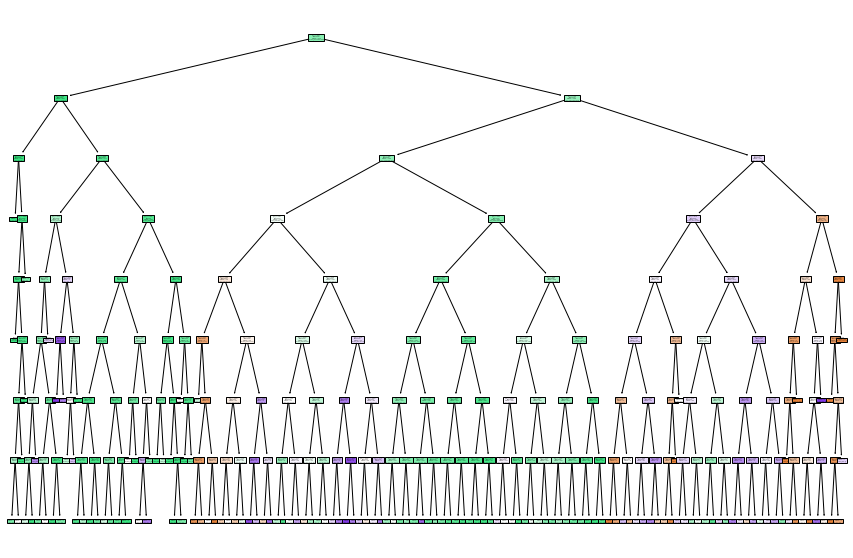

In [85]:
fig = plt.figure(figsize=(15, 10))
_ = tree.plot_tree(best_clf, filled=True)

<a id='section5.5'></a>

**Random Forest Grid Search**

Rinse and repeat: Let's do the same procedure for a random forest classifier: fit a grid, train it and check the score!

In [86]:
#instantiate rf classifier

rf = RandomForestClassifier()

In [87]:
#get parameters

rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [88]:
#define the grid of hyperparameters

params_rf = {'max_depth': range(1,10),
             'criterion' :['gini', 'entropy'],
             'max_features': ['auto', 'log2', 'sqrt'],
             'n_estimators': [200, 500]}

#instantiate a 5-fold CV grid search object

grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='accuracy', cv=5, n_jobs=-1)

In [89]:
# fit grid to the training data

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [200, 500]},
             scoring='accuracy')

In [90]:
#extract best hyperparameters from grid

best_hyperparams = grid_rf.best_params_
print('Best hyperparameters: \n', best_hyperparams)

Best hyperparameters: 
 {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'n_estimators': 200}


In [91]:
#extract best CV score from grid

best_CV_score = grid_rf.best_score_
print('Best CV accuracy:', best_CV_score)

Best CV accuracy: 0.7228550229854342


In [92]:
#extract best model from grid

best_model = grid_rf.best_estimator_

In [93]:
#confusion matrix with validation set

y_valid_pred = best_model.predict(X_valid)
confusion_matrix(y_valid, y_valid_pred)

array([[  81,  282,  107],
       [  17, 4215,  107],
       [  36, 1181,  202]])

In [94]:
#evaluate accuracy with validation set

test_acc = best_model.score(X_valid, y_valid)
print('Validation set accuracy of best model: {:.3f}'.format(test_acc))

Validation set accuracy of best model: 0.722


Our random forest model is performing slightly better than the decision tree. Let's move on with this one! :)

<a id='section5.6'></a>

**Feature Importances**

Next, we need to select the features which we want to include in our models. Therefore, we will take a look at MDI and MDA feature importance.

* MDI feature Importances

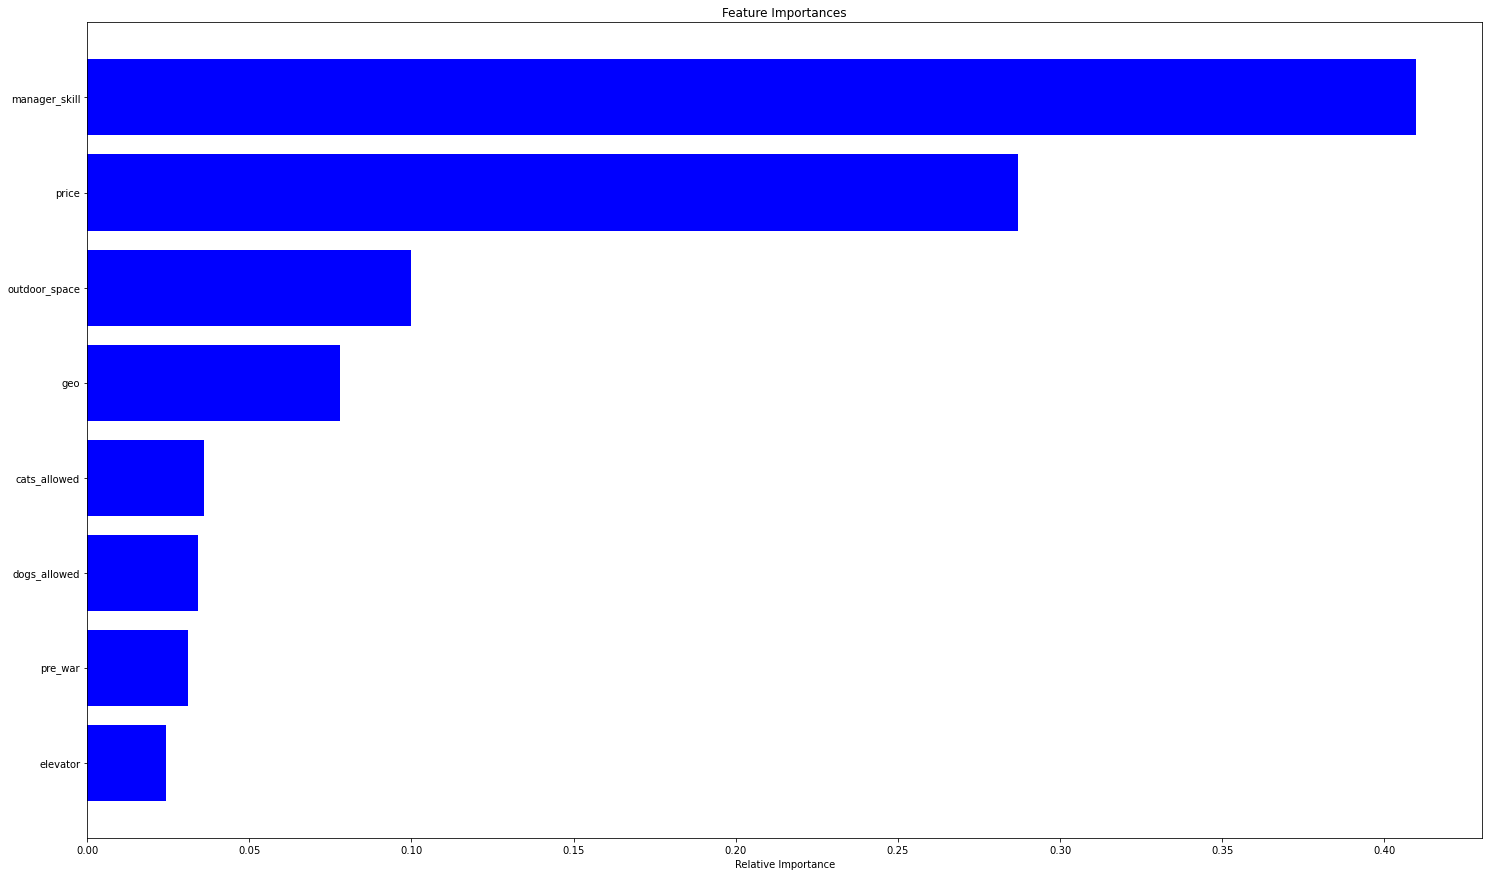

In [95]:
#random forest feature importances (MDI)

plt.figure(figsize=(25, 15))
importances = best_model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

According to the MDI (Mean Decreased Impurity) let's us know that the feature 'manager_skill' contributed most to the success in prediction. Therefore, it's the most important feature followed by 'price'.

* MDA / Permutation Importances

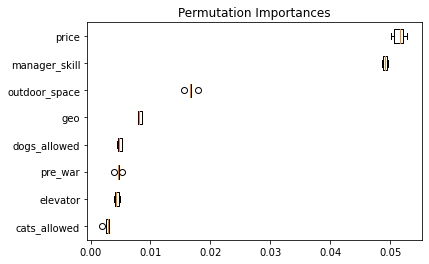

In [96]:
#permutation importance
MDA_importances = permutation_importance(best_model, X_train, y_train, n_repeats=5,random_state=42, n_jobs=2)
sorted_idx = MDA_importances.importances_mean.argsort()

plt.boxplot(MDA_importances.importances[sorted_idx].T,
           vert=False, labels=features[sorted_idx])
tpmp=plt.title("Permutation Importances")
#fig.tight_layout()

The permutation importance provides another output than the MDI. According to the MDA, price is the most important feature, followed by manager skill. The only features from the MDI that remain the same for the ranking are outdoor_space and geo. 

In [98]:
#pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

In [99]:
perm = PermutationImportance(best_model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0519 ± 0.0017,price
0.0490 ± 0.0021,manager_skill
0.0153 ± 0.0017,outdoor_space
0.0080 ± 0.0005,geo
0.0051 ± 0.0007,dogs_allowed
0.0047 ± 0.0007,elevator
0.0046 ± 0.0008,pre_war
0.0029 ± 0.0006,cats_allowed


The values at the very top which are price and manager_skill are the most important features, and those at the bottom the least. The first number tells us how much accuracy decreases with a random shuffling. The second number shows how the performance varied from one shuffling to the next. If this number is large, as we can see for price or manager_skill, it means that it is an important feature. It almost nothing changed, such as for cats_allowed, it means that it is an unimportant feature. 

In [101]:
#permutation importance
pi_features = eli5.explain_weights_df(perm, feature_names = X_train.columns.tolist())
pi_features = pi_features.loc[pi_features['weight'] >= 0.01]['feature'].tolist()

In [102]:
print("\nFeatures from permutation importance", pi_features)


Features from permutation importance ['price', 'manager_skill', 'outdoor_space']


Only three features had a higher treshold that we set of 0.01. Let us take a look at the shap values next.

<a id='section5.7'></a>

**SHAP Values**

SHAP Values (SHapley Additive exPlanations) break down a prediction to show the impact of each feature.

In [1]:
data_for_prediction = X_valid.iloc[0,:]  # use 1 row of data here. Could use multiple rows if desired

# Create object that can calculate shap values
explainer = shap.TreeExplainer(best_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

NameError: name 'X_valid' is not defined

The f(x) is the prediction for that observation (the prediction of the first row 0.16).

The base value is the value that would be predicted if we did not know any features for the current output. It is the mean prediction (yhat). 

Red/blue: Features that push the prediction from the base balue higher to the right to the output. The biggest contributer here is for example price. Pushing the prediction lower are seen in blue as for instance outdoor_space or elevator.

The means of the variables are: X_train.mean()

In [104]:
X_train.mean()

geo              5602.857843
price               0.001062
pre_war            -0.006280
dogs_allowed       -0.007361
cats_allowed       -0.003301
elevator           -0.004104
outdoor_space       0.001062
manager_skill       0.000558
dtype: float64

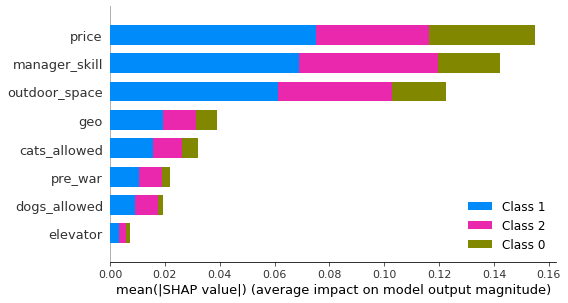

In [105]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

The above is the variable importance plot (Global Interpretability), which shows a list of the most significant variables in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power. It is the same output that the feature importance gave us.

As the top 8 features seem to contain features which pushed the model score lower, it is recommended to keep a look at the feature selection part again to find ways to improve the procedure or to try a different method to identify the top features. 

In [ ]:
#shap.dependence_plot('price', shap_values[0], X_train)

In [ ]:
#shap.dependence_plot('manager_skill', shap_values[0], X_train)

<a id='section5.8'></a>

**Final fit on test data**

In [106]:
#evaluate accuracy with test set

test_acc = best_model.score(X_test, y_test)
print('Validation set accuracy of best model: {:.3f}'.format(test_acc))

Validation set accuracy of best model: 0.716
